In [157]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from keras import backend as K
from sklearn.model_selection import train_test_split


In [158]:
df_credit = pd.read_csv("../data/interim/creditcard_min_max.csv")

In [159]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = gumbel_sample((batch, dim))
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [160]:
latent_dim = 128
encoder_inputs = Input(shape=(31), name="input_layer")

n_x1 = 256
x1 = Dense(n_x1, activation="relu", name="h1")(encoder_inputs)
x2 = Dense(n_x1, activation="relu", name="h2")(x1)

# Split x3 into two halves
half_size = n_x1 // 2
x1_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x2)
x1_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x2)

z_mean = Dense(latent_dim, name="z_mean")(x1_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x1_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 31)]         0           []                               
                                                                                                  
 h1 (Dense)                     (None, 256)          8192        ['input_layer[0][0]']            
                                                                                                  
 h2 (Dense)                     (None, 256)          65792       ['h1[0][0]']                     
                                                                                                  
 select_z_mean (Lambda)         (None, 128)          0           ['h2[0][0]']                     
                                                                                            

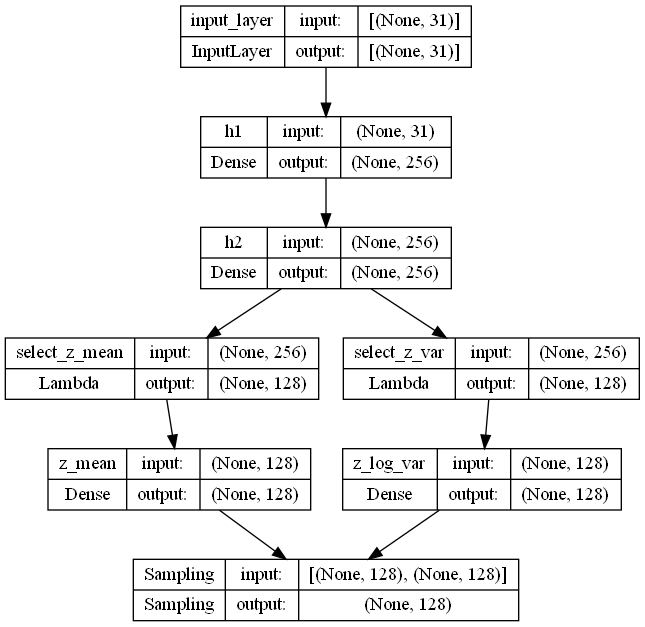

In [161]:
keras.utils.plot_model(encoder, show_shapes=True)

In [162]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x4 = 256
x4 = Dense(n_x4, activation="relu", name="h4")(latent_inputs)
x5 = Dense(n_x4, activation="relu", name="h5")(x4)
cont_decoder_outputs = Dense(30, activation = 'linear', name="cont_decoder_output")(x5)
class_decoder_output = Dense(1, activation="sigmoid", name="classification_output")(x5)
decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 h4 (Dense)                     (None, 256)          33024       ['input_7[0][0]']                
                                                                                                  
 h5 (Dense)                     (None, 256)          65792       ['h4[0][0]']                     


                                                                                                  
 cont_decoder_output (Dense)    (None, 30)           7710        ['h5[0][0]']                     
                                                                                                  
 classification_output (Dense)  (None, 1)            257         ['h5[0][0]']                     
                                                                                                  
Total params: 106,783
Trainable params: 106,783
Non-trainable params: 0
__________________________________________________________________________________________________


In [163]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_class_tracker = keras.metrics.Mean(
            name="reconstruction_loss_class"
        )
        self.mean_abs_diff_cont_tracker = keras.metrics.Mean(name='mean_abs_diff_cont')
        self.mean_abs_diff_class_tracker = keras.metrics.Mean(name='mean_abs_diff_class')
        self.mean_binary_tracker = keras.metrics.Mean(name="mean_binary_value")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_class_tracker,

        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[
                :, :30
            ]  # Assuming the first 4 columns are for continuous variables
            data_class = data[:, 30:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.binary_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + kl_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "sparse_categorical_crossentropy": self.reconstruction_loss_class_tracker.result(), 
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]  # Unpack the tuple and take the input data

        data_cont = data[:, :30]  # Assuming the first 4 columns are for continuous variables
        data_class = data[:, 30:]  # Assuming the last column is for classification

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction_cont, reconstruction_class =self.decoder(z)

        reconstruction_loss_cont = keras.losses.mean_squared_error(
            data_cont, reconstruction_cont
        )

        # Reconstruction loss for classification output
        reconstruction_loss_class = keras.losses.binary_crossentropy(
            data_class, reconstruction_class
        )

        kl_loss = -0.5 * (
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # Combine losses
        total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + kl_loss
            )

        # Compute mean absolute differences and mean of binary data
        mean_abs_diff_cont = tf.reduce_mean(tf.abs(data_cont - reconstruction_cont))
        mean_abs_diff_class = tf.reduce_mean(tf.abs(data_class - reconstruction_class))
        mean_binary_value = tf.reduce_mean(tf.cast(reconstruction_class >= 0.5, tf.float32))

        # Update the loss tracker
        self.total_loss_tracker.update_state(total_loss)

        # Update other metrics
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.mean_abs_diff_cont_tracker.update_state(mean_abs_diff_cont)
        self.mean_abs_diff_class_tracker.update_state(mean_abs_diff_class)
        self.mean_binary_tracker.update_state(mean_binary_value)

        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mean_abs_diff_cont": self.mean_abs_diff_cont_tracker.result(),
            "mean_abs_diff_class": self.mean_abs_diff_class_tracker.result(),
            "mean_binary_value": self.mean_binary_tracker.result(),
        }

In [164]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [165]:
credit_array = df_credit.values
total_length = len(credit_array)  # Get the total number of elements in credit_array


twenty_percent_length = int(0.2 * total_length)  # Calculate 20% of the total length
# Slice the first 20 percent of the values in credit_array
credit_array_cut = credit_array[:twenty_percent_length]

# Specify the test_size and validation_size according to your needs
test_size = 0.2  # 80% training, 20% test
validation_size = 0.1  # 80% training, 10% validation

# Split into training and temporary data
train_data, temp_data = train_test_split(
    credit_array_cut, test_size=test_size + validation_size, random_state=42
)

# Split the temporary data into test and validation
test_data, validation_data = train_test_split(
    temp_data,
    test_size=validation_size / (test_size + validation_size),
    random_state=42,
)

In [166]:
from keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the best model observed during training
)

hist = vae.fit(
    train_data,
    epochs=100,
    batch_size=32,
    validation_data=(test_data,None),  # Provide validation data here
    callbacks=[early_stopping_callback],
)


Epoch 1/100
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0529 - reconstruction_loss_cont: 0.0351 - reconstruction_loss_class: 0.0058 - kl_loss: 0.0017 - sparse_categorical_crossentropy: 0.0152 - val_loss: 0.0045 - val_reconstruction_loss_cont: 0.0035 - val_reconstruction_loss_class: 2.9942e-04 - val_kl_loss: 7.1634e-04 - val_mean_abs_diff_cont: 0.0444 - val_mean_abs_diff_class: 2.4837e-04 - val_mean_binary_value: 0.0028
Epoch 2/100
 142/1246 [==>...........................] - ETA: 2s - loss: 0.0047 - reconstruction_loss_cont: 0.0036 - reconstruction_loss_class: 2.7185e-04 - kl_loss: 6.8312e-04 - sparse_categorical_crossentropy: 3.2322e-04

KeyboardInterrupt: 

In [ ]:
latent_vectors = np.random.normal(scale=1.5, size=(11392, latent_dim)
)  # gumbel_sample((20000, latent_dim))
# np.random.normal(size=(20000, latent_dim))

# Use the decoder to generate data


generated_data_cont, generated_data_class = vae.decoder.predict(latent_vectors)

356/356 [==============================] - 0s 1ms/step


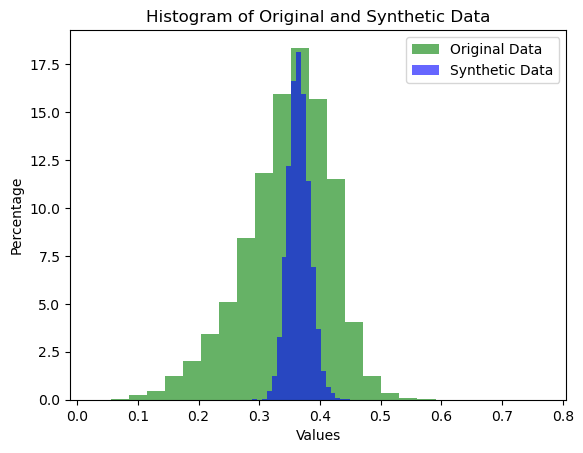

In [ ]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
colum_num = 15
original_column = train_data[:, colum_num]

synth_column = generated_data_cont[:, colum_num]

# Calculate the percentage for original_column
total_points_original = len(original_column)
percentage_original = (original_column / total_points_original) * 100

# Calculate the percentage for synth_column
total_points_synth = len(synth_column)
percentage_synth = (synth_column / total_points_synth) * 100

# Plot histograms
plt.hist(
    original_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(original_column) / total_points_original * 100,
    label="Original Data",
)

plt.hist(
    synth_column,
    bins=25,
    color="b",
    alpha=0.6,
    weights=np.ones_like(synth_column) / total_points_synth * 100,
    label="Synthetic Data",
)

plt.title("Histogram of Original and Synthetic Data")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.legend()

plt.show()